In [0]:
import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout,Embedding, Bidirectional, Conv1D, BatchNormalization, CuDNNLSTM, GlobalAveragePooling1D
from keras.layers import  MaxPooling1D, Embedding, concatenate, Flatten
from keras.models import Model
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import optimizers, regularizers, initializers, layers, constraints
from keras.optimizers import Adam,RMSprop
from keras.engine.topology import Layer
from keras import backend as K


Using TensorFlow backend.


In [0]:
np.random.seed(42)
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

import pickle


pickle_in = open("/content/drive/My Drive/newlyrics.txt", "rb")
texts = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/newgenre.txt", "rb")
labels = pickle.load(pickle_in)

print("text size: %g" %len(texts))
print()
print("label size: %g" %len(labels))



from sklearn.preprocessing import LabelEncoder
# converts the character array to numeric array. Assigns levels to unique labels.

le = LabelEncoder() 
le.fit(labels)
labels = le.transform(labels)


print(le.classes_)
print(np.unique(labels, return_counts=True))


text size: 44195

label size: 44195
['Country' 'Hip-Hop' 'Metal' 'Pop' 'Rock']
(array([0, 1, 2, 3, 4]), array([8839, 8839, 8839, 8839, 8839]))


In [0]:
dict(zip(le.classes_, range(1, len(le.classes_)+1)))

{'Country': 1, 'Hip-Hop': 2, 'Metal': 3, 'Pop': 4, 'Rock': 5}

In [0]:
from keras.preprocessing.text import Tokenizer
tokenizer=Tokenizer()
tokenizer.fit_on_texts(texts)

In [0]:
vocab_size=len(tokenizer.index_word)

sequence_length=1000

data = dict()

data["vocab_size"] = vocab_size

data["sequence_length"] = sequence_length

data["texts"] = texts

data["labels"] = labels

In [0]:
def tokenize_text(data):
    tokenizer = Tokenizer(num_words=data["vocab_size"])
    tokenizer.fit_on_texts(data["texts"])
    data["tokenizer"] = tokenizer
    sequences = tokenizer.texts_to_sequences(data["texts"])

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    data["X"] = pad_sequences(sequences, maxlen=data["sequence_length"])
    data["y"] = to_categorical(np.asarray(data["labels"]))
    print('Shape of data tensor:', data["X"].shape)
    print('Shape of label tensor:', data["y"].shape)

    # texts and labels aren't needed anymore
    data.pop("texts", None)
    data.pop("labels", None)
    return data
  
  
data = tokenize_text(data)



Found 185131 unique tokens.
Shape of data tensor: (44195, 1000)
Shape of label tensor: (44195, 5)


In [0]:
def train_val_test_split(data):

    data["X_train"], X_test_val, data["y_train"],  y_test_val = train_test_split(data["X"], data["y"], test_size=0.25)
    data["X_val"], data["X_test"], data["y_val"], data["y_test"] = train_test_split(X_test_val, y_test_val, test_size=0.5)
    return data

data = train_val_test_split(data)  
data["embedding_dim"] = 100

In [0]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]


In [0]:

def build_network(vocab_size, embedding_dim, sequence_length):
  
    input = Input(shape=(sequence_length,), name="Input")
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length,
                          name="embedding")(input)
    
    
    x = Bidirectional(CuDNNLSTM(16, return_sequences=True))(embedding)
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    x = AttentionWithContext()(x)
    x = Dropout(0.5)(x)
    x = Dense(64, kernel_regularizer=regularizers.l1(0.001),activation="relu")(x)
    
    output = Dense(5, activation="softmax")(x)
    
    model = Model(inputs=input, outputs=output)
    #adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.99, epsilon=None, decay=1e-7,clipnorm=1.0)
    adam=RMSprop(lr=1e-3,rho=0.9,decay=0.01)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model  
  
  
model = build_network(vocab_size=data["vocab_size"], embedding_dim=data['embedding_dim'], sequence_length=data['sequence_length'])

print(model.summary())

callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

history=model.fit(data["X_train"], data["y_train"], batch_size=32, epochs=50, callbacks=callbacks, shuffle=True,validation_data=(data["X_val"], data["y_val"]))

model.save("nusicGenre_model_word_embedding.h5")

score, acc = model.evaluate(x=data["X_test"], y=data["y_test"],batch_size=128)






Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 1000)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1000, 100)         18513100  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1000, 32)          15104     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1000, 128)         50176     
_________________________________________________________________
attention_with_context_1 (At (None, 128)               16640     
_________________________________________________________________
dropout_1 (Dropout)  

In [0]:
print(acc)

0.6316742082203136


In [0]:

#predictions on test data

predicted=model.predict(data["X_test"])
predicted

#model evaluation

import sklearn
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(data["y_test"], predicted.round())

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

print("############################")

print(sklearn.metrics.classification_report(data["y_test"], predicted.round()))

precision: [0.6780303  0.85814889 0.78051088 0.60708263 0.40853659]
recall: [0.64215247 0.79422719 0.73203194 0.32549729 0.06074343]
fscore: [0.65960387 0.82495164 0.75549451 0.42377869 0.10576164]
support: [1115 1074 1127 1106 1103]
############################
              precision    recall  f1-score   support

           0       0.68      0.64      0.66      1115
           1       0.86      0.79      0.82      1074
           2       0.78      0.73      0.76      1127
           3       0.61      0.33      0.42      1106
           4       0.41      0.06      0.11      1103

   micro avg       0.73      0.51      0.60      5525
   macro avg       0.67      0.51      0.55      5525
weighted avg       0.67      0.51      0.55      5525
 samples avg       0.51      0.51      0.51      5525



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


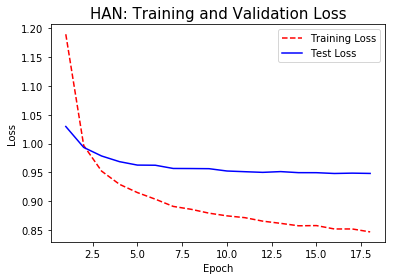

In [0]:
import matplotlib.pyplot as plt
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.title('HAN: Training and Validation Loss',fontsize=15)
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('HAN-VAL&TRAINING_LOSS.png')
plt.show();

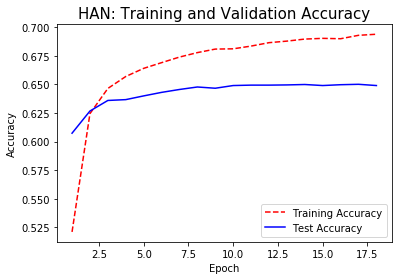

In [0]:
import matplotlib.pyplot as plt
# Get training and test loss histories
training_loss = history.history['acc']
test_loss = history.history['val_acc']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.title('HAN: Training and Validation Accuracy',fontsize=15)
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig('HAN-VAL&TRAINING_ACC.png')
plt.show();

In [0]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    
    plt.xlabel('Epochs')
    plt.title('HAN: Training and Validation Loss',fontsize=15)
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('HAN_VAL&TRAINING_LOSS.png')
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    
    plt.xlabel('Epochs')
    plt.title('HAN: Training and Validation Accuracy',fontsize=15)
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('HAN_VAL&TRAINING_ACC.png')
    plt.show()
   

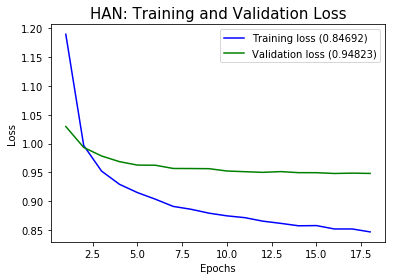

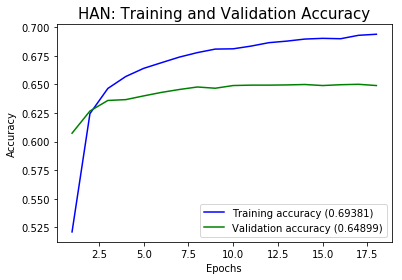

In [0]:
plot_history(history)

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)